In [35]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [21]:
data = pd.read_csv("AAPL.csv")
print(data.head())

        Price               Close                High                 Low                Open     Volume
0      Ticker                AAPL                AAPL                AAPL                AAPL       AAPL
1        Date                 NaN                 NaN                 NaN                 NaN        NaN
2  2021-01-04  125.97447204589844  130.06296894085764  123.39482183574111  129.97536179433877  143301900
3  2021-01-05  127.53199005126953  128.24262097829288  125.02048114625119  125.46827577350281   97664900
4  2021-01-06  123.23905944824219  127.57092663069263  123.02489875437408  124.32932869572905  155088000


In [22]:
print("columns are:", data.columns)                          

columns are: Index(['Price', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [23]:
data = data[['Close']]
print(data.head())

                Close
0                AAPL
1                 NaN
2  125.97447204589844
3  127.53199005126953
4  123.23905944824219


In [25]:
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
data = data.dropna()

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1255 entries, 2 to 1256
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1255 non-null   float64
dtypes: float64(1)
memory usage: 19.6 KB
None


In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(data)

print("Scaled Data Shape:", scaled_data.shape)

Scaled Data Shape: (1255, 1)


In [27]:
X = []
y = []

for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i])
    y.append(scaled_data[i])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1195, 60, 1)
y shape: (1195, 1)


In [28]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train:", X_train.shape)
print("Test :", X_test.shape)

Train: (956, 60, 1)
Test : (239, 60, 1)


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [30]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True,
               input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(1))

In [31]:
model.compile(optimizer='adam', loss='mean_squared_error')
print("Model Compiled Successfully")

Model Compiled Successfully


In [32]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/5
30/30 [==============================] - 12s 136ms/step - loss: 0.0311 - val_loss: 0.0050
Epoch 2/5
30/30 [==============================] - 2s 68ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 3/5
30/30 [==============================] - 3s 104ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 4/5
30/30 [==============================] - 3s 111ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 5/5
30/30 [==============================] - 3s 99ms/step - loss: 0.0026 - val_loss: 0.0029


In [33]:
predicted = model.predict(X_test)

predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test)

print(predicted_prices[:5])

8/8 [==============================] - 2s 21ms/step
[[241.25006]
 [239.3388 ]
 [237.35828]
 [235.39421]
 [233.48607]]


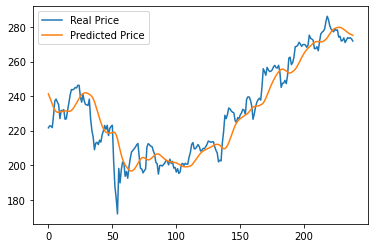

In [36]:
plt.plot(real_prices, label="Real Price")
plt.plot(predicted_prices, label="Predicted Price")
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
mae = mean_absolute_error(real_prices, predicted_prices)

print("RMSE:", rmse)
print("MAE :", mae)

RMSE: 9.246103381388345
MAE : 6.889878851599272


In [38]:
future_days = 30

last_60 = scaled_data[-60:]
future_predictions = []

for i in range(future_days):
    X_future = last_60.reshape(1, 60, 1)

    next_price = model.predict(X_future)

    future_predictions.append(next_price[0][0])

    last_60 = np.append(last_60[1:], next_price)

future_predictions = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1, 1)
)

print("Next 30 Days Predictions:")
print(future_predictions)

1/1 [==============================] - 0s 41ms/step
Next 30 Days Predictions:
[[274.8816 ]
 [274.69412]
 [274.597  ]
 [274.56677]
 [274.5851 ]
 [274.63776]
 [274.714  ]
 [274.8062 ]
 [274.90894]
 [275.01843]
 [275.13217]
 [275.24854]
 [275.3664 ]
 [275.48508]
 [275.60425]
 [275.7235 ]
 [275.84286]
 [275.96213]
 [276.08127]
 [276.2003 ]
 [276.31918]
 [276.43784]
 [276.55637]
 [276.67465]
 [276.79276]
 [276.91068]
 [277.02835]
 [277.1458 ]
 [277.26303]
 [277.38   ]]


In [39]:
model.save("stock_lstm_model.h5")
print("Model saved successfully!")

Model saved successfully!
